In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_dict(dataset_dict, separate=True):
    tensors = list()
    for label, arr in dataset_dict.items():
        # convert this from arr to tensor after numpy change
        dataset_samples = arr.shape[0]
        input_tensor = torch.from_numpy(arr)
        label_tensor = torch.full((dataset_samples, ), label)
        if separate:
            tensors.append((input_tensor, label_tensor))
        else:
            tensor = torch.cat([input_tensor, label_tensor], dim=1)
            tensors.append(tensor)
            
    if separate:
        input_tensors, label_tensors = zip(*tensors)
        input_tensor = torch.cat(input_tensors, dim=0).unsqueeze(axis=1).double()
        label_tensor = torch.cat(label_tensors, dim=0).double()
        return input_tensor, label_tensor
    else:
        tensor = torch.cat(tensors, dim=0).double()
        return tensor
    
class TorchDataset(Dataset):
    def __init__(self, input_tensor, label_tensor):
        assert input_tensor.shape[0] == label_tensor.shape[0], f'{input_tensor.shape} != {label_tensor.shape[0]}'
        self._data = input_tensor
        self._label = label_tensor
        return
    
    @property
    def shape(self):
        return self._data.shape

    def __len__(self):
        return self._data.shape[0]

    def __getitem__(self, index):
        data = self._data[index]
        label = self._label[index]
        return data, label

In [3]:
dataset_samples = 10_000
amps = [1,.5,.25,.15,.05,.005]
dataset_dict = {
    amp : WaveGen(size=240).linear_phase(n_periods=1).cos().amp(amp).t_noise(std=.01, dof=5).sample().samples
    for amp
    in amps
}

In [4]:
data, labels = torch_data_from_dict(dataset_dict)
train_data, test_data, train_labels, test_labels = torch_train_test_split(data, labels, split=.9)

train_dataset = TorchDataset(train_data, train_labels)
test_dataset = TorchDataset(test_data, test_labels)

torch.Size([6000, 1, 240])

torch.Size([6000])

In [5]:
class SineCNN(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
        drop=.4, 
        dense_size=32
    ):
        super(SineCNN, self).__init__()
        conv1_out_shape = (input_size - kernel_size) // stride + 1
        pool_out_shape = (conv1_out_shape - pool_kernel) // pool_kernel + 1
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.maxpool = nn.MaxPool1d(kernel_size=pool_kernel)
        self.fc1 = nn.Linear(pool_out_shape * out_channels, dense_size)
        self.dout1 = nn.Dropout(p=drop)
        self.fc2 = nn.Linear(dense_size, 1)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dout1(x)
        x = self.fc2(x)
        x = self.output(x).squeeze()
        return x
    

In [6]:
class SineMLP(nn.Module):
    def __init__(
        self, 
        input_size, 
        dense_size=256,
        n_skips=2,
        reduction=.5,
        drop=.4, 
    ):
        super(SineMLP, self).__init__()
        self.fc_input = nn.Linear(input_size, dense_size)
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.skips = list()
        for _ in range(n_skips):
            if int(dense_size * reduction ** 2) < 1:
                warnings.warn('Too many skips applied, ignoring')
                continue
            skip, dense_size = self.skip_layer(dense_size, reduction=reduction, drop=drop)
            self.skips.append(skip)
        if dense_size != 1:
            self.fc_output = nn.Linear(dense_size, 1)
        self.output = nn.Sigmoid()
        return
        
    def skip_layer(self, input_size, reduction=.5, drop=.4):
        l1_size = int(input_size * reduction)
        l2_size = int(l1_size * reduction)

        skip_block = nn.Sequential(
            nn.Linear(input_size, l1_size),
            nn.BatchNorm2d(l1_size),
            nn.LeakyReLU(negative_slope=.2, inplace=True),
            nn.Dropout(p=drop),
            nn.Linear(l1_size, l2_size),
            nn.BatchNorm2d(l2_size),
        )
        return skip_block, l2_size

    def forward(self, x):
        x = self.fc_input(x)
        x = self.activation(x)
        for skip in self.skips:
            x += skip(x)
        x = self.fc_output(x)
        x = self.output(x).squeeze()
        return x

In [7]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_data)
            
            train_loss = criterion(train_output, train_labels)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_data)
            test_loss = criterion(test_output, test_labels)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_data, train_label = train_dataset[:]
            test_data, test_label = test_dataset[:]
            train_output = model(train_data)
            train_loss = criterion(train_output, train_label)
            test_output = model(test_data)
            test_loss = criterion(test_output, test_label)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [8]:
out_channelss = [2,4]
kernel_sizes = [48]
strides = [1,2,4,8]
pool_kernels = [2,4,8]
dense_sizes = [16,20,24]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels), len(dense_sizes)))

columns = ['out_channels','kernel_size','stride','pool_kernel','dense_size','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel, dense_size) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels, dense_sizes)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, dense_size, sep='|')
    
    model = SineCNN(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
        dense_size=dense_size,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        ) 
    except RuntimeError as re:
        print(re)
        continue
    if not len(items):
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, dense_size, train_loss, test_loss))

grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
# grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

Input Set 1 out of 72
2|48|1|2|16
Input Set 2 out of 72
2|48|1|2|20
Input Set 3 out of 72
2|48|1|2|24


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 4 out of 72
2|48|1|4|16
Input Set 5 out of 72
2|48|1|4|20
Input Set 6 out of 72
2|48|1|4|24
Input Set 7 out of 72
2|48|1|8|16
Input Set 8 out of 72
2|48|1|8|20
Input Set 9 out of 72
2|48|1|8|24
Input Set 10 out of 72
2|48|2|2|16
Input Set 11 out of 72
2|48|2|2|20
Input Set 12 out of 72
2|48|2|2|24
Input Set 13 out of 72
2|48|2|4|16
Input Set 14 out of 72
2|48|2|4|20
Input Set 15 out of 72
2|48|2|4|24
Input Set 16 out of 72
2|48|2|8|16
Input Set 17 out of 72
2|48|2|8|20
Input Set 18 out of 72
2|48|2|8|24
Input Set 22 out of 72
2|48|4|4|16
Input Set 23 out of 72
2|48|4|4|20
Input Set 24 out of 72
2|48|4|4|24
Input Set 25 out of 72
2|48|4|8|16
Input Set 26 out of 72
2|48|4|8|20
Input Set 27 out of 72
2|48|4|8|24
Input Set 34 out of 72
2|48|8|8|16
Input Set 35 out of 72
2|48|8|8|20
Input Set 36 out of 72
2|48|8|8|24
Input Set 37 out of 72
4|48|1|2|16
Input Set 38 out of 72
4|48|1|2|20
Input Set 39 out of 72
4|48|1|2|24
Input Set 40 out of 72
4|48|1|4|16
Input Set 41 out of 72
4|4

,out_channels,kernel_size,stride,pool_kernel,dense_size,train_loss,test_loss
0,2,48,1,2,16,0.127009,0.131363
1,2,48,1,2,24,NaN,NaN
2,2,48,1,4,16,0.217265,0.221377
3,2,48,1,4,20,0.122422,0.127879
4,2,48,1,4,24,0.118546,0.124118
5,2,48,1,8,16,0.118803,0.124428
6,2,48,1,8,20,0.120882,0.124290
7,2,48,1,8,24,0.118139,0.124183
8,2,48,2,2,16,0.169587,0.179592
9,2,48,2,2,20,0.173083,0.183971


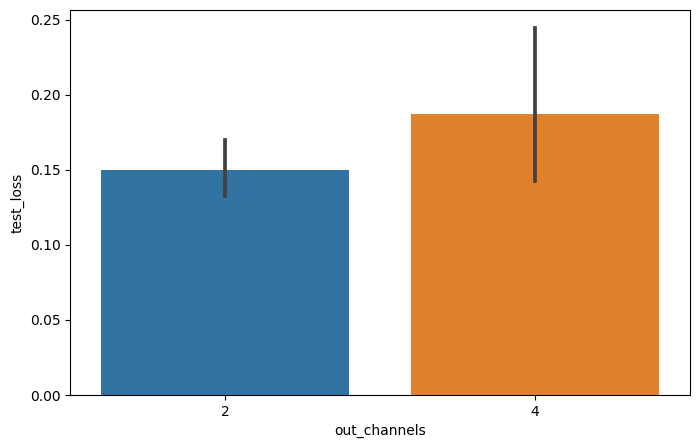

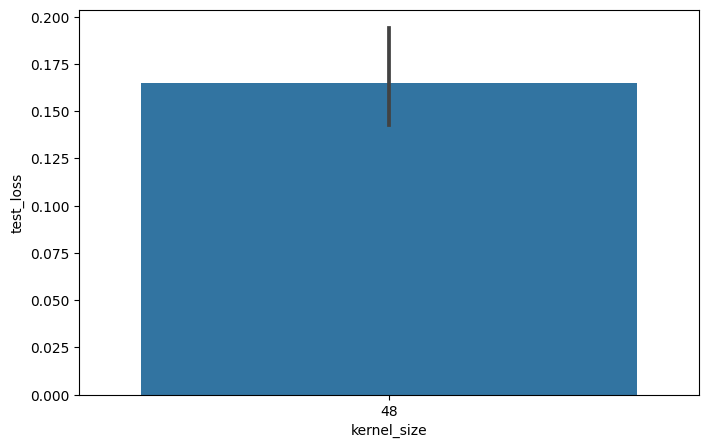

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


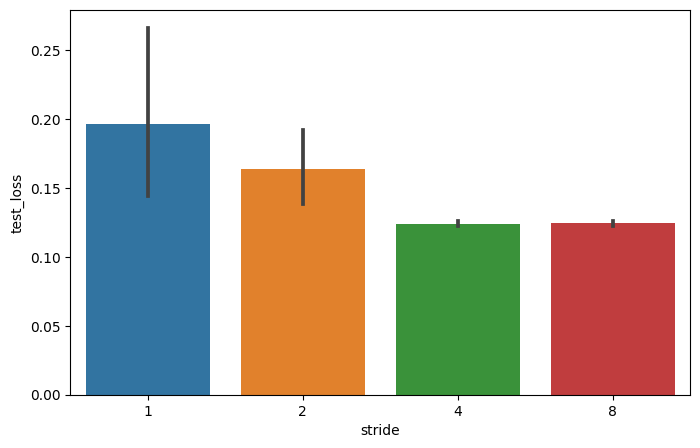

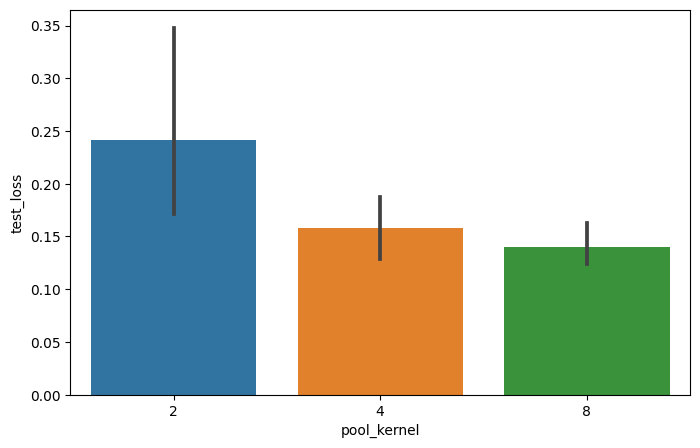

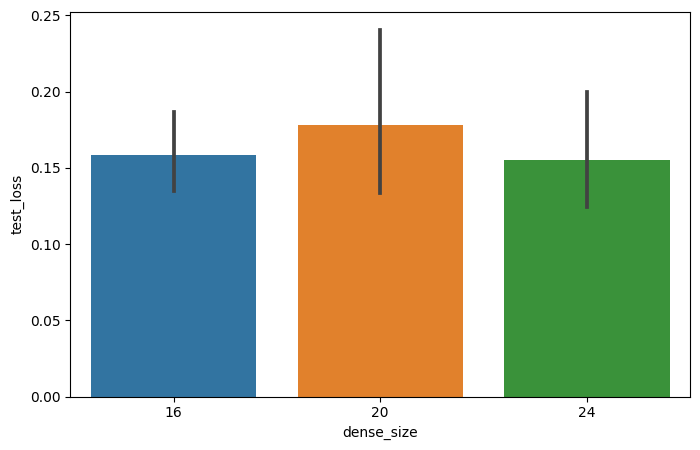

In [9]:
for col in ['out_channels','kernel_size','stride','pool_kernel','dense_size']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

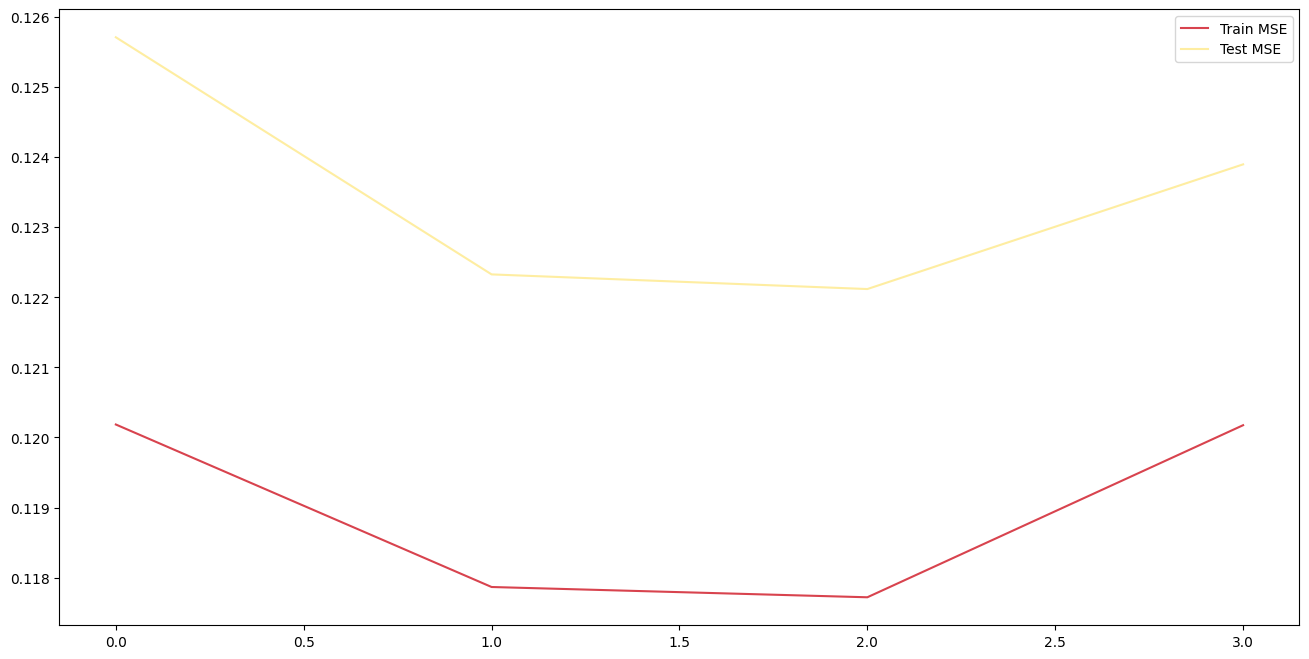

In [10]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

model = SineCNN(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(model, train_dataset, test_dataset, n_epochs=100, test_full=True, early_stop_patience=30) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_cnn_regressor.pt')